In [1]:
# Block 1: Importing Libraries and Setting Parameters
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from keras_tuner.tuners import Hyperband  # Updated import

# Define paths
train_dir = "/kaggle/input/facial-recognition-dataset/Training/Training"
test_dir = "/kaggle/input/facial-recognition-dataset/Testing/Testing"

# Parameters
img_size = (140, 140)
batch_size = 64
validation_split = 0.2
seed = 123

# Classes
class_names = sorted(os.listdir(train_dir))


In [2]:
# Block 2: Data Augmentation and Dataset Loading
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.1),
], name="data_augmentation")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 28273 files belonging to 6 classes.
Using 22619 files for training.
Found 28273 files belonging to 6 classes.
Using 5654 files for validation.
Found 7067 files belonging to 6 classes.


In [3]:
# Block 3: Preprocessing Functions
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    image = tf.keras.layers.Rescaling(1./127.5, offset=-1)(image)
    return image, label

def preprocess_test_data(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.layers.Rescaling(1./127.5, offset=-1)(image)
    return image, label

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_test_data, num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(buffer_size=2000, seed=seed, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [4]:
# Block 4: Computing Class Weights
new_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}
class_indices = {name: idx for idx, name in enumerate(class_names)}
y_train = np.hstack([[class_indices[class_name]] * count for class_name, count in new_class_counts.items()])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights)


Class Weights: {0: 1.1795160617438465, 1: 1.1501505166381905, 2: 0.6531069531069531, 3: 0.9490768714333669, 4: 0.9756038647342995, 5: 1.486019131714496}


In [12]:
# Block 5: Keras Tuner for Learning Rate Tuning
def build_model(hp):
    base_model = Xception(input_shape=img_size + (3,), include_top=False, weights='imagenet')
    for layer in base_model.layers[:-80]:  # Unfreeze more layers for better fine-tuning
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_initializer='he_normal'),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_initializer='he_normal'),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dropout(0.3),
        Dense(len(class_names), activation='softmax', kernel_initializer='he_normal', dtype='float32')
    ])
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-4, 3e-4, 5e-4, 1e-3])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Initialize Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='facial_recognition_tuning'
)

# Search for the best hyperparameters
tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 4 Complete [00h 06m 28s]
val_accuracy: 0.5286523103713989

Best val_accuracy So Far: 0.5643792152404785
Total elapsed time: 00h 24m 05s
Best learning rate: 0.0005


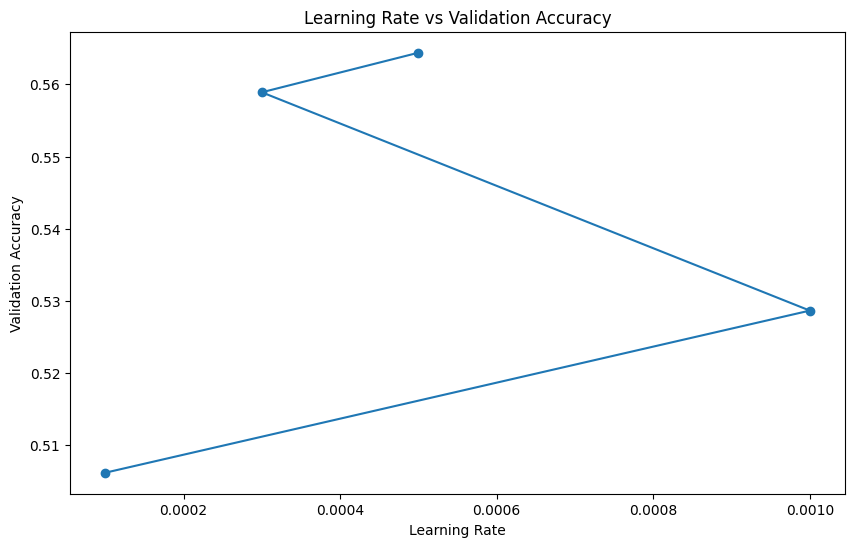

In [13]:
# Block 6: Visualize Tuning Results
tuning_results = tuner.oracle.get_best_trials(num_trials=10)
val_accuracies = [trial.metrics.get_best_value('val_accuracy') for trial in tuning_results]
lr_values = [trial.hyperparameters.get('learning_rate') for trial in tuning_results]

plt.figure(figsize=(10, 6))
plt.plot(lr_values, val_accuracies, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Validation Accuracy')
plt.show()

In [14]:
# Save the best hyperparameters to a JSON file
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters to a JSON file
import json
tuning_results_file = "best_hyperparameters.json"

with open(tuning_results_file, "w") as f:
    json.dump(best_hps.values, f)

print(f"Best hyperparameters saved to {tuning_results_file}")


Best hyperparameters saved to best_hyperparameters.json


In [5]:
# Block: Load Tuning Results and Train the Model
import json
from keras_tuner.engine.hyperparameters import HyperParameters

# Path to the saved hyperparameters file
tuning_results_file = "/kaggle/input/lnlmlm/best_hyperparameters (2).json"

# Load the best hyperparameters from the JSON file
with open(tuning_results_file, "r") as f:
    best_hps_values = json.load(f)

# Reconstruct the HyperParameters object
loaded_hps = HyperParameters()
for key, value in best_hps_values.items():
    loaded_hps.Fixed(key, value)

# Build the model using the saved hyperparameters
final_model = Sequential([
    Xception(input_shape=img_size + (3,), include_top=False, weights='imagenet'),
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_initializer='he_normal'),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_initializer='he_normal'),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax', kernel_initializer='he_normal', dtype='float32')
])

# Compile the model using the saved learning rate
final_model.compile(
    optimizer=Adam(learning_rate=loaded_hps.get('learning_rate')),  # Use the saved learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model_xception_original_classes.keras", save_best_only=True, monitor="val_loss")
tensorboard = TensorBoard(log_dir="logs_xception_original_classes")

# Train the model
history = final_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,  # Adjust based on available resources and performance
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, checkpoint, tensorboard]
)



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 315s 544ms/step - accuracy: 0.3148 - loss: 14.4411 - val_accuracy: 0.4880 - val_loss: 5.8453 - learning_rate: 5.0000e-04
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 200s 442ms/step - accuracy: 0.4962 - loss: 4.4992 - val_accuracy: 0.5331 - val_loss: 2.1336 - learning_rate: 5.0000e-04
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 198s 440ms/step - accuracy: 0.5609 - loss: 1.8690 - val_accuracy: 0.5707 - val_loss: 1.4320 - learning_rate: 5.0000e-04
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 197s 440ms/step - accuracy: 0.5911 - loss: 1.3417 - val_accuracy: 0.5914 - val_loss: 1.2207 - learning_rate: 5.0000e-04
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 197s 436ms/step - accuracy: 0.6146 - loss: 1.1853 - val_accuracy: 0.5849 - val_loss: 1.2240 - learning_rate: 5.0000e-04
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 199s 442ms/step - accuracy: 0.6165 - loss: 1.1751 - val_accuracy: 0.6082 - val_loss: 1.1427 - learning_rate:

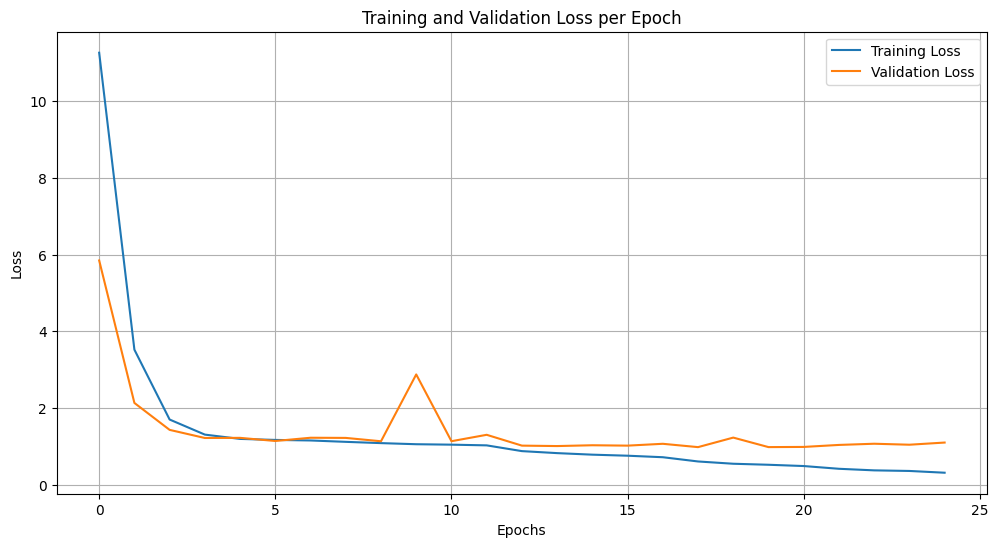

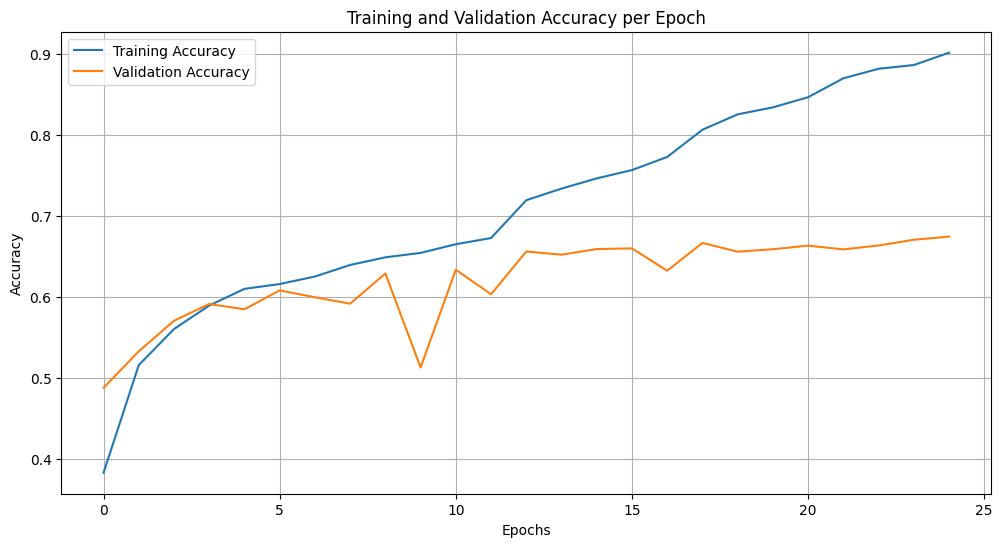

In [6]:
# Visualize Training and Validation Metrics
import matplotlib.pyplot as plt

# Retrieve metrics from history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [7]:
# Block 8: Evaluate Final Model
final_model.load_weights("best_model_xception_original_classes.keras")
loss, accuracy = final_model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.6524 - loss: 1.0217
Test Accuracy: 68.30%


In [8]:
# Save the trained model
model_save_path = "final_xception_model.h5"
final_model.save(model_save_path)
print(f"Model training complete. Saved as {model_save_path}")


Model training complete. Saved as final_xception_model.h5
